# Split Cycle

This notebook contains an efficient algorithm for computing the Split Cycle voting method from "[Split Cycle: A New Condorcet Consistent Voting Method Independent of Clones and Immune to Spoilers](https://arxiv.org/abs/2004.02350)" by Wesley H. Holliday and Eric Pacuit.  


In [4]:
from pref_voting.profiles import *
from pref_voting.generate_profiles import *
from pref_voting.generate_weighted_majority_graphs import *
from pref_voting.voting_methods import *
from itertools import chain, combinations, permutations

In [5]:
def has_strong_path(A, source, target, k):
    """Given a square matrix A, return True if there is a path from source to target in the associated directed graph
    where each edge has a weight greater than or equal to k, and False otherwise."""
    
    n = A.shape[0] # assume A is a square matrix
    visited = np.zeros(n, dtype=bool)

    def dfs(node):
        if node == target:
            return True
        visited[node] = True
        for neighbor, weight in enumerate(A[node, :]):
            if weight >= k and not visited[neighbor]:
                if dfs(neighbor):
                    return True
        return False

    return dfs(source)

def split_cycle(edata, curr_cands = None, strength_function = None):
    """If x has a positive margin over y and there is no path from y back to x of strength at least the margin of x over y, then x defeats y. The candidates that are undefeated are the Split Cycle winners.
    """
    
    candidates = edata.candidates if curr_cands is None else curr_cands  

    if strength_function is None: 
        strength_matrix = np.array(edata.m_matrix) if isinstance(edata,MarginGraph) else np.array(edata.margin_matrix())
    else:
        strength_matrix = np.array([[strength_function(a,b) for b in candidates] for a in candidates])

    strength_function = edata.margin if strength_function is None else strength_function 

    potential_winners = set(edata.candidates)

    for a in candidates:
        for b in candidates:
            if strength_function(b,a) > 0 and not has_strong_path(strength_matrix, a, b, strength_function(b,a)):
                potential_winners.discard(a)
                break

    return sorted(potential_winners)

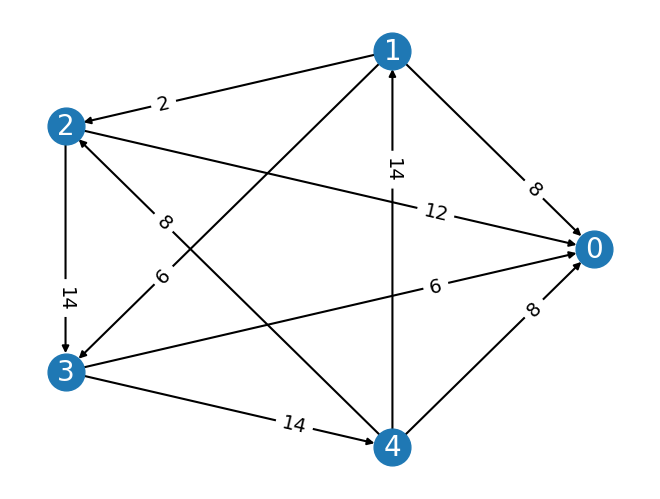

The Split Cycle winners are [2]


In [10]:
mg = generate_margin_graph(5)
mg.display()
print("The Split Cycle winners are", split_cycle(mg))

In [11]:
# Speed comparison of Split Cycle vs. Beat Path

mgs = [generate_margin_graph(20) for _ in range(100)]

In [12]:
%timeit [split_cycle(mg) for mg in mgs]

75.3 ms ± 1.23 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [13]:
%timeit [beat_path_faster(mg) for mg in mgs]

176 ms ± 1.06 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)
